<span class="mathmacros" style="display:none;">
$\def\bra#1{\mathinner{\langle{#1}|}}
\def\ket#1{\mathinner{|{#1}\rangle}}
\def\braket#1{\mathinner{\langle{#1}\rangle}}
\newcommand{\mdef}{\overset{\mathrm{def}}{=}}
\newcommand{\bm}{\mathbf}
\newcommand{\inv}[1]{#1^{-1}}   % Inverse Matrix
\newcommand{\invt}[1]{#1^{-T}}  % Inverse Transposed Matrix
\renewcommand{\nl}{\\&\phantom{{}={}}}% Newline In aligned equations
\newcommand{\pfr}[2]{\frac{\pp #1}{\pp #2}}      % Partial derivative
\newcommand{\dfr}[2]{\frac{\dd #1}{\dd #2}}      % Total derivative
\newcommand{\pp}{\partial}
\DeclareMathOperator{\Var}{Var}
\DeclareMathOperator{\det}{det}
\DeclareMathOperator{\tr}{tr}
\DeclareMathOperator{\sgn}{sgn}
\DeclareMathOperator{\adj}{adj}
\DeclareMathOperator{\ii}{i}
\DeclareMathOperator{\dd}{d}
\DeclareMathOperator{\rhs}{RHS}
\DeclareMathOperator{\lhs}{LHS}
\newcommand{\nl}{\\&\phantom{={}}}
\DeclareMathOperator{\E}{E}
\DeclareMathOperator{\Cov}{Cov}
\DeclareMathOperator{\Beta}{B}
\DeclareMathOperator{\Bdist}{Beta}$
</span>

## Q1
> You say that the initial global density matrix is obtained by taking the Kronecker product of identical density matrices $\rho_i$ on each site and conjugating by a random unitary $U$. Does it matter what $U$ is? As you are optimizing the cost function over the set of unitaries that can conjugate $\rho$, do you not always find the same optimized unitary $V$, irrespective of the starting $U$?

From the data, it really matters what $U$ is. For different starting $U$, they are not converging to the same density matrix. Roger suggested that I do not apply random unitary to $\rho$ and keep it diagonalized in the $Z$ basis. I will test whether this will make some difference.

## Q2
> Why is the $\beta$ of the optimized $\rho$ always “small”? As you are fixing the entropy density $S/n$, should you not find a beta that is related to $S/n$? I think this is the curve that Roger was asking for.

Although the entire spectrum of $\rho$ is fixed, entropy of each site is not fixed under a __global__ unitary transformation. The reasons $\beta$ is near $0$ might be the following:

When we are minimizing energy variance, ideally the first order derivative should be $0$ which means $\rho$ must be diagonal in energy basis. Thus the (invariant) eigenvalues of $\rho$ must be "distributed" to energy eigenstates. The energy spectrum of Hamiltonian is typically sparse near minimum/maximum energy and dense near center. To minimize energy variance, the dominant eigenvalues of $\rho$ are distributed to energy levels at dense area. This makes $\langle H\rangle$ neither very high or very low, which corresponds to a low $\beta$ value.

1 0.945 0.809


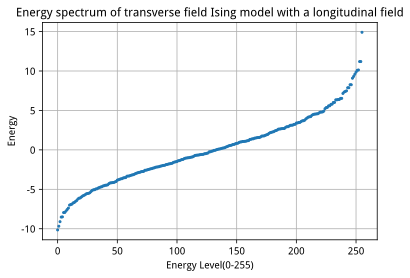

In [21]:
import Ising
w, v=eigh(Ising.Hamilton_TL(8))
plot(w, '.', markersize=4);
xlabel('Energy Level(0-255)')
ylabel('Energy');
title('Energy spectrum of transverse field Ising model with a longitudinal field')
grid();

## Q3
> I didn’t understand the method to generate initial $\rho$ with random eigenvalues.

Which point is not clear, could you explain? It is basically generating a random $\rho$ and then tune its entropy by power. It is just a trick without physical significance. Another better way may be randomly distribute entropy to different sites.

# Q4
> Have you tried the method on a translationally invariant non-integrable Hamiltonian with no disorder? For example: $$H = \sum_i J Z_i Z_{i+1}+ g X_i + h Z_i $$
> this is the transverse field Ising model with a longitudinal field. For $(g,h,J) = (0.9045, 0.8090, 1)$, it numerically satisfies the ETH pretty well at small system sizes. How well does your method work for this? What kinds of optimized $\rho$ does it produce? 

I do not know how well it is, but a simple run of this Hamiltonian with above parameters gives the following figure. 

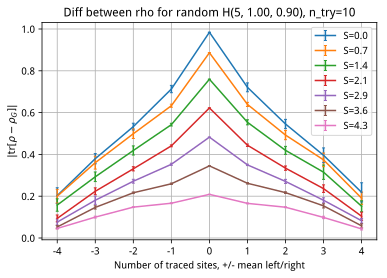

In [24]:
import analyse as al
from importlib import reload
reload(al)
al.draw_diff_rho(5, al.Hamilton_TL, 1, 0.9045, rs=None, ns=8)

## Q5
> Also, what’s the bottleneck in your code? (you say it takes several hours with N=6?) I guess it’s the optimization; how are you implementing it? 

On average, every optimization process (with 3000 steepest descent steps) of $\mathrm{Var}[H]$ costs about $1$ minute, and every step costs about 20ms, which is large for 64 by 64 matrices (n=6). I think the bottleneck is really on optimization. I will later profile the performance and make some improvement accordingly. 

### Implementation of optimization
Suppose $h$ is a Hermitian matrix, then $U=e^{ih}$ is unitary. The optimization is iteratively applying $U_i=e^{ih_i}$ at step $i$ to give a better $$\rho_{i+1}=e^{ih_i}\rho_i e^{-ih_i}$$
to minimize
$$f(h_i)=\tr[H^2U_i\rho_i U_i^+]-\tr^2[HU_i\rho_i U_i^+]$$

The optimization at each step is using gradient $M=\nabla_h f$ to give a descent direction. Then consider $h_i=xM$, we can find first and second order derivative over $x$, which gives an estimation on best step size $x=-f'/f''$. 